#### **Purpose:**
This cell is dedicated to importing all the necessary Python libraries and modules required for the entire modeling and evaluation phase.

#### **Code Functionality:**
* It imports **pandas (pd)** for data manipulation, **numpy (np)** for numerical operations, and **matplotlib.pyplot (plt)** and **seaborn (sns)** for data visualization.
* Key machine learning modules from **sklearn** are imported: `LogisticRegression` for the baseline model, `StandardScaler` for feature scaling, and various metrics functions from `sklearn.metrics` for comprehensive model evaluation.
* **xgboost.XGBClassifier** is imported, anticipating its use in enhanced models.
* `warnings.filterwarnings('ignore')` is used to suppress warnings, providing a cleaner output during execution.

#### **Output Analysis:**
This cell does not produce any direct console output; its purpose is to make the necessary libraries available for subsequent code execution.

In [42]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from xgboost import XGBClassifier
from sklearn.metrics import classification_report, roc_auc_score, roc_curve, precision_recall_curve, f1_score, confusion_matrix, ConfusionMatrixDisplay
from sklearn.preprocessing import StandardScaler
# Suppress warnings for cleaner output in a notebook environment
import warnings
warnings.filterwarnings('ignore')

#### **Purpose:**
This cell defines the core configuration parameters that control the data loading, splitting, and prediction horizon for the modeling phase.

#### **Code Functionality:**
* **PROCESSED_DATA_PATH**: Specifies the file path to the `final_prepared_data.csv` generated in Notebook 01.
* **PREDICTION_HORIZON**: Set to 6, indicating that the model will predict recessions occurring within the next 6 months.
* **TRAIN_END_DATE**: Sets the cutoff date for the training set (2000-12-31).
* **VALIDATION_END_DATE**: Sets the cutoff date for the validation set (2010-12-31).

#### **Output Analysis:**
The output confirms the starting of the modeling phase and explicitly states the prediction horizon and the data split dates, ensuring clarity on the experimental setup.

In [43]:
# --- Configuration ---
PROCESSED_DATA_PATH = 'E:/Project_3/Recession_Prediction_Network_Analysis/data/final_prepared_data.csv'
PREDICTION_HORIZON = 6 # Months
TRAIN_END_DATE = '2000-12-31'
VALIDATION_END_DATE = '2010-12-31'

print(f"Starting Phase 2: Baseline Recession Prediction Model with a {PREDICTION_HORIZON}-month prediction horizon.")
print(f"Data split points: Train up to {TRAIN_END_DATE}, Validate up to {VALIDATION_END_DATE}, Test thereafter.")
print("-" * 60)

Starting Phase 2: Baseline Recession Prediction Model with a 6-month prediction horizon.
Data split points: Train up to 2000-12-31, Validate up to 2010-12-31, Test thereafter.
------------------------------------------------------------


#### **Purpose:**
This cell is responsible for loading the clean, pre-processed, and feature-engineered data from Phase 1, which will serve as the input for the machine learning models.

#### **Code Functionality:**
* The code attempts to load the CSV file specified by `PROCESSED_DATA_PATH`.
* It dynamically identifies the index column and sets it as the DataFrame's index, parsing it as datetime objects. The index is then renamed to 'Date', and its frequency is set to 'ME' (Month End).
* Robust error handling (`try-except`) is implemented to catch `FileNotFoundError` or other exceptions during the loading process.
* After successful loading, it prints the data range, total number of rows, and displays the head and info of the DataFrame.

#### **Output Analysis:**
The output confirms successful data loading from 1961 to 2025 with 774 rows. The `.head()` and `.info()` commands verify that all 48 features and the 'Recession' target column are present and contain no null values.

In [44]:
# Load the final prepared data
try:
    # Dynamically find the date column name, which might be 'Unnamed: 0'
    temp_df = pd.read_csv(PROCESSED_DATA_PATH)
    ACTUAL_DATE_COLUMN_NAME = temp_df.columns[0]
    
    df_ml = pd.read_csv(PROCESSED_DATA_PATH, index_col=ACTUAL_DATE_COLUMN_NAME, parse_dates=True)
    df_ml.index.name = 'Date' # Rename the index to 'Date' for consistency
    df_ml.index.freq = 'ME' # Ensure month-end frequency is set
    
    print(f"Successfully loaded data from: {PROCESSED_DATA_PATH}")
    print(f"Data range: {df_ml.index.min()} to {df_ml.index.max()}")
    print(f"Number of rows: {len(df_ml)}")
    print("\nInitial df_ml head:")
    print(df_ml.head())
    print("\nInitial df_ml info:")
    df_ml.info()

except FileNotFoundError:
    print(f"Error: {PROCESSED_DATA_PATH} not found. Please ensure your processed data from Phase 1 is saved correctly.")
    print("Exiting Phase 2 execution.")
    exit()
except Exception as e:
    print(f"\nAn error occurred during loading: {e}")
    print("Please check the column names in your CSV file and ensure the correct 'index_col' is used.")
    exit()
print("-" * 60)

Successfully loaded data from: E:/Project_3/Recession_Prediction_Network_Analysis/data/final_prepared_data.csv
Data range: 1961-01-31 00:00:00 to 2025-06-30 00:00:00
Number of rows: 774

Initial df_ml head:
            T10Y3MM_mom_change  T10Y3MM_yoy_change  T10Y3MM_roll12_mean  \
Date                                                                      
1961-01-31                 0.0                 0.0                 1.67   
1961-02-28                 0.0                 0.0                 1.67   
1961-03-31                 0.0                 0.0                 1.67   
1961-04-30                 0.0                 0.0                 1.67   
1961-05-31                 0.0                 0.0                 1.67   

            T10Y3MM_roll12_std  ICSA_mom_change  ICSA_yoy_change  \
Date                                                               
1961-01-31                 0.0              0.0              0.0   
1961-02-28                 0.0              0.0              0.

#### **Purpose:**
This cell prepares the dataset for machine learning by defining the feature set (X) and creating a future-looking target variable (y). It also handles any infinite values that may have arisen from feature engineering.

#### **Code Functionality:**
* **Target Creation**: A `Recession_future` column is created by shifting the original `Recession` column upwards by `PREDICTION_HORIZON` (6 months).
* **Initial Processing**: The original `Recession` column is dropped to prevent data leakage, and rows with `NaN` (from the shift) are removed.
* **Infinite Value Handling**: `np.inf` values are replaced with `np.nan` and then dropped to ensure clean numerical data.
* **X and y Definition**: `X` is defined as all columns except `Recession_future`, and `y` is set to the `Recession_future` column, cast to integer type.
* **Validation**: The code prints the shapes, heads/tails, and class distribution of X and y to verify the process.

#### **Output Analysis:**
The output confirms that a few rows were dropped due to NaN/inf values. The shapes of X (766, 48) and y (766,) are shown. The class distribution reveals a significant imbalance, with recessions accounting for only 11.10% of the target data.

In [45]:
# --- Step 2.1: Defining Features (X) and Target (y) ---
print("\nStep 2.1: Defining Features (X) and Target (y)")

df_ml['Recession_future'] = df_ml['Recession'].shift(-PREDICTION_HORIZON)

# Drop rows where the target is NaN and the original 'Recession' column
df_ml_processed = df_ml.drop(columns=['Recession']).dropna()

# Handle Infinite Values in Features that may arise from pct_change(0)
df_ml_processed.replace([np.inf, -np.inf], np.nan, inplace=True)
initial_rows = len(df_ml_processed)
df_ml_processed.dropna(inplace=True)
rows_after_drop = len(df_ml_processed)
print(f"Dropped {initial_rows - rows_after_drop} rows containing NaN/inf values after feature engineering.")

# Define features (X) and target (y)
X = df_ml_processed.drop(columns=['Recession_future'])
y = df_ml_processed['Recession_future']
y = y.astype(int)

# Print shapes and distributions for verification
print(f"Shape of X: {X.shape}")
print(f"Shape of y: {y.shape}")
print(f"\nClass distribution of y (0=No Recession, 1=Recession in next {PREDICTION_HORIZON} months):")
print(y.value_counts())
print(f"Percentage of recession periods in target: {y.value_counts(normalize=True).get(1, 0) * 100:.2f}%")

# Sanity check for NaNs
if X.isnull().sum().sum() == 0:
    print("\nNo NaN values found in features (X).")
else:
    print("\nWARNING: NaN values still present in features (X).")

print("-" * 60)


Step 2.1: Defining Features (X) and Target (y)
Dropped 2 rows containing NaN/inf values after feature engineering.
Shape of X: (766, 48)
Shape of y: (766,)

Class distribution of y (0=No Recession, 1=Recession in next 6 months):
Recession_future
0    681
1     85
Name: count, dtype: int64
Percentage of recession periods in target: 11.10%

No NaN values found in features (X).
------------------------------------------------------------


#### **Purpose:**
This cell performs a chronological split of the dataset into training, validation, and test sets. This method is essential for time-series forecasting to prevent data leakage from the future into the past.

#### **Code Functionality:**
* Data is split based on the `TRAIN_END_DATE` and `VALIDATION_END_DATE`.
* The shapes and target class distributions for each split are printed to confirm the partitioning.
* All split datasets are saved to separate CSV files for reproducibility.

#### **Output Analysis:**
The output clearly outlines the periods and shapes of each dataset: Training (480 rows), Validation (120 rows), and Test (166 rows). It also shows the percentage of recession periods in each set, highlighting the severe class imbalance in the test period (1.20%).

In [46]:
#--- Step 2.2: Time-Series Split for Training, Validation, and Testing ---
print("\nStep 2.2: Time-Series Split for Training, Validation, and Testing")

# Split the data chronologically
X_train = X[X.index <= TRAIN_END_DATE]
y_train = y[y.index <= TRAIN_END_DATE]

X_val = X[(X.index > TRAIN_END_DATE) & (X.index <= VALIDATION_END_DATE)]
y_val = y[(y.index > TRAIN_END_DATE) & (y.index <= VALIDATION_END_DATE)]

X_test = X[X.index > VALIDATION_END_DATE]
y_test = y[y.index > VALIDATION_END_DATE]

print(f"Training period: {X_train.index.min()} to {X_train.index.max()}")
print(f"Training set shape (X, y): {X_train.shape}, {y_train.shape}")
print(f"Train target distribution (1s): {y_train.value_counts(normalize=True).get(1, 0) * 100:.2f}%")

print(f"\nValidation period: {X_val.index.min()} to {X_val.index.max()}")
print(f"Validation set shape (X, y): {X_val.shape}, {y_val.shape}")
print(f"Validation target distribution (1s): {y_val.value_counts(normalize=True).get(1, 0) * 100:.2f}%")

print(f"\nTest period: {X_test.index.min()} to {X_test.index.max()}")
print(f"Test set shape (X, y): {X_test.shape}, {y_test.shape}")
print(f"Test target distribution (1s): {y_test.value_counts(normalize=True).get(1, 0) * 100:.2f}%")

# Save the split datasets for potential later use
X_train.to_csv('E:/Project_3/Recession_Prediction_Network_Analysis/data/X_train.csv')
y_train.to_csv('E:/Project_3/Recession_Prediction_Network_Analysis/data/y_train.csv')
X_val.to_csv('E:/Project_3/Recession_Prediction_Network_Analysis/data/X_val.csv')
y_val.to_csv('E:/Project_3/Recession_Prediction_Network_Analysis/data/y_val.csv')
X_test.to_csv('E:/Project_3/Recession_Prediction_Network_Analysis/data/X_test.csv')
y_test.to_csv('E:/Project_3/Recession_Prediction_Network_Analysis/data/y_test.csv')
print("\nSplit datasets saved to the data folder.")
print("-" * 60)


Step 2.2: Time-Series Split for Training, Validation, and Testing
Training period: 1961-01-31 00:00:00 to 2000-12-31 00:00:00
Training set shape (X, y): (480, 48), (480,)
Train target distribution (1s): 12.50%

Validation period: 2001-01-31 00:00:00 to 2010-12-31 00:00:00
Validation set shape (X, y): (120, 48), (120,)
Validation target distribution (1s): 19.17%

Test period: 2011-01-31 00:00:00 to 2024-12-31 00:00:00
Test set shape (X, y): (166, 48), (166,)
Test target distribution (1s): 1.20%

Split datasets saved to the data folder.
------------------------------------------------------------


#### **Purpose:**
This cell performs feature scaling on the split datasets and then initializes and trains the baseline Logistic Regression model.

#### **Code Functionality:**
* **Feature Scaling**: A `StandardScaler` is initialized. It is `fit_transform`ed on the training data `X_train` and then used to `.transform()` `X_val` and `X_test`, preventing data leakage.
* **Model Training**: A `LogisticRegression` model is initialized with `class_weight='balanced'` to counteract class imbalance. The model is then trained (`.fit()`) on the scaled training data.

#### **Output Analysis:**
The output confirms that features have been scaled and shows the head of the transformed `X_train_scaled` DataFrame. It also confirms that the Logistic Regression model was trained successfully.

In [47]:
# --- Step 2.3: Model Selection & Training (Baseline Logistic Regression) ---
print("\nStep 2.3: Model Selection & Training (Baseline Logistic Regression)")

# 1. Feature Scaling
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train.values)
X_val_scaled = scaler.transform(X_val.values)
X_test_scaled = scaler.transform(X_test.values)

# Convert back to DataFrame to retain column names and index
X_train_scaled = pd.DataFrame(X_train_scaled, columns=X_train.columns, index=X_train.index)
X_val_scaled = pd.DataFrame(X_val_scaled, columns=X_val.columns, index=X_val.index)
X_test_scaled = pd.DataFrame(X_test_scaled, columns=X_test.columns, index=X_test.index)

print("\nFeatures scaled using StandardScaler (fitted on training data).")

# 2. Initialize and Train Logistic Regression Model
log_reg_model = LogisticRegression(class_weight='balanced', solver='liblinear', random_state=42, max_iter=1000)
print("\nTraining Logistic Regression model...")
log_reg_model.fit(X_train_scaled, y_train)
print("Logistic Regression model trained successfully.")
print("-" * 60)


Step 2.3: Model Selection & Training (Baseline Logistic Regression)

Features scaled using StandardScaler (fitted on training data).

Training Logistic Regression model...
Logistic Regression model trained successfully.
------------------------------------------------------------


#### **Purpose:**
This cell evaluates the performance of the trained Logistic Regression model on the validation set using various metrics and visualizations.

#### **Code Functionality:**
* **Predictions**: Generates binary predictions (`y_val_pred`) and class probabilities (`y_val_prob`) on the scaled validation set.
* **Metric Calculation**: Prints a `classification_report` (precision, recall, F1-score) and calculates the `roc_auc_score`.
* **Visualizations**: Plots the Confusion Matrix, Receiver Operating Characteristic (ROC) Curve, and Precision-Recall Curve to visually assess model performance.

#### **Output Analysis:**
The model shows reasonable performance on the validation set. The ROC AUC Score is **0.8427**. For the recession class (1), precision is 0.50 and recall is 0.48, indicating it correctly identified about half of the recessions in this period. The generated plots provide a visual confirmation of these metrics.


Step 2.4: Model Evaluation on Validation Set (Logistic Regression)

--- Logistic Regression Validation Set Performance ---

Classification Report:
              precision    recall  f1-score   support

           0       0.88      0.89      0.88        97
           1       0.50      0.48      0.49        23

    accuracy                           0.81       120
   macro avg       0.69      0.68      0.69       120
weighted avg       0.81      0.81      0.81       120

ROC AUC Score: 0.8427

Confusion Matrix:


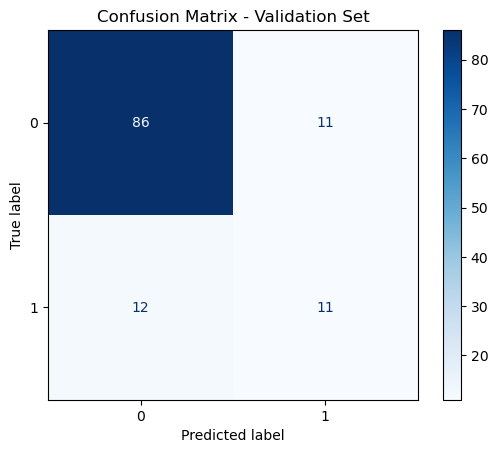

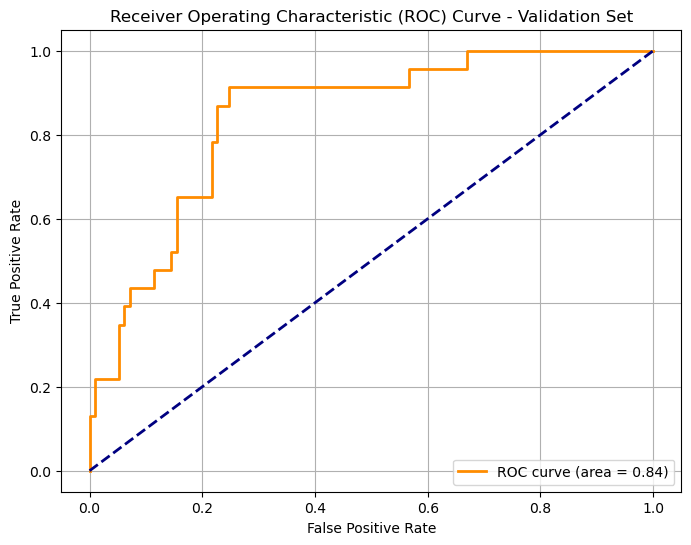

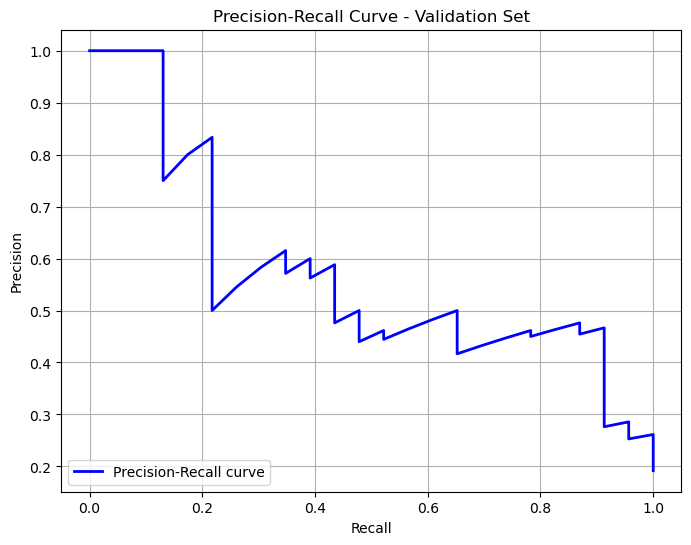

------------------------------------------------------------


In [48]:
# --- Step 2.4: Model Evaluation on Validation Set (Logistic Regression) ---
print("\nStep 2.4: Model Evaluation on Validation Set (Logistic Regression)")

# Predictions on the validation set
y_val_pred = log_reg_model.predict(X_val_scaled)
y_val_prob = log_reg_model.predict_proba(X_val_scaled)[:, 1]

print("\n--- Logistic Regression Validation Set Performance ---")
# Classification Report
print("\nClassification Report:")
print(classification_report(y_val, y_val_pred))

# ROC AUC Score
roc_auc = roc_auc_score(y_val, y_val_prob)
print(f"ROC AUC Score: {roc_auc:.4f}")

# Confusion Matrix
print("\nConfusion Matrix:")
cm = confusion_matrix(y_val, y_val_pred)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=log_reg_model.classes_)
disp.plot(cmap=plt.cm.Blues)
plt.title('Confusion Matrix - Validation Set')
plt.show()

# Plotting ROC Curve
fpr, tpr, _ = roc_curve(y_val, y_val_prob)
plt.figure(figsize=(8, 6))
plt.plot(fpr, tpr, color='darkorange', lw=2, label=f'ROC curve (area = {roc_auc:.2f})')
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC) Curve - Validation Set')
plt.legend(loc="lower right")
plt.grid(True)
plt.show()

# Plotting Precision-Recall Curve
precision, recall, _ = precision_recall_curve(y_val, y_val_prob)
plt.figure(figsize=(8, 6))
plt.plot(recall, precision, color='blue', lw=2, label='Precision-Recall curve')
plt.xlabel('Recall')
plt.ylabel('Precision')
plt.title('Precision-Recall Curve - Validation Set')
plt.grid(True)
plt.legend(loc="lower left")
plt.show()

print("-" * 60)

#### **Purpose:**
This cell conducts the final, unbiased evaluation of the baseline model on the test set, providing a realistic assessment of its generalization performance on unseen data.

#### **Code Functionality:**
* **Predictions**: Generates binary predictions (`y_test_pred`) and class probabilities (`y_test_prob`) on the scaled test set.
* **Metric Calculation**: Prints a `classification_report` and calculates the `roc_auc_score` for the test set.
* **Visualizations**: Plots the Confusion Matrix, ROC Curve, and Precision-Recall Curve for the test set.

#### **Output Analysis:**
The baseline model's performance degrades significantly on the test set. The ROC AUC Score is **0.5488**, which is close to random guessing. The classification report shows that both **precision and recall for the recession class (1) are 0.00**, meaning the model failed to identify any of the true recessions in the test period. This poor result highlights the limitations of the baseline model and motivates the need for the enhanced models in the next phase.


Step 2.5: Model Evaluation on Test Set (Logistic Regression)

--- Logistic Regression Test Set Performance ---

Classification Report:
              precision    recall  f1-score   support

           0       0.99      0.94      0.96       164
           1       0.00      0.00      0.00         2

    accuracy                           0.93       166
   macro avg       0.49      0.47      0.48       166
weighted avg       0.98      0.93      0.95       166

ROC AUC Score: 0.5488

Confusion Matrix:


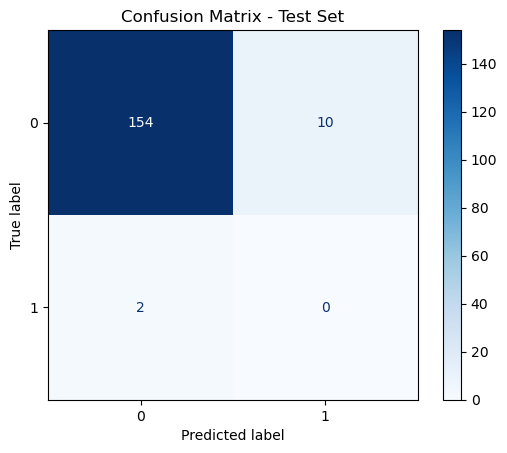

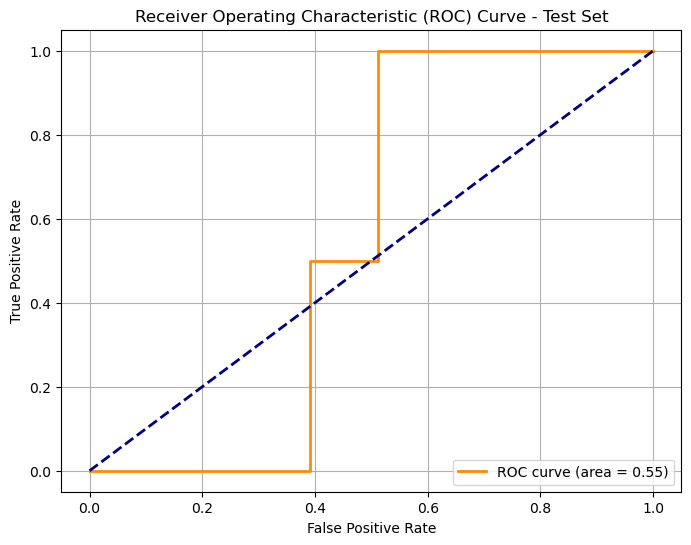

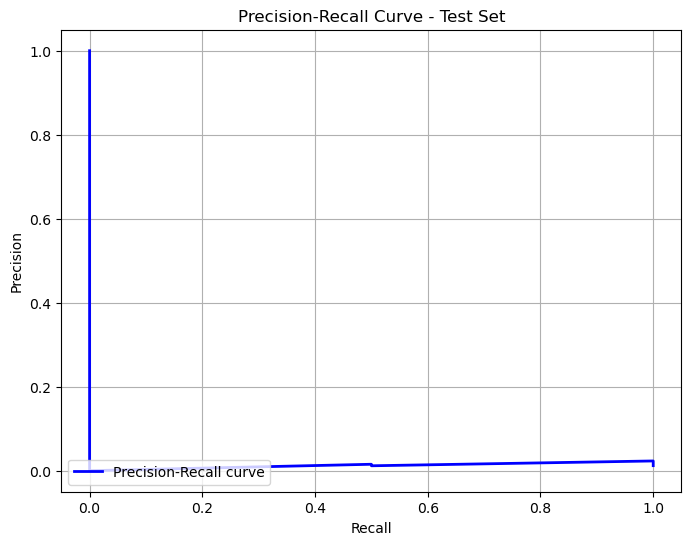

------------------------------------------------------------


In [49]:
# --- Step 2.5: Model Evaluation on Test Set (Logistic Regression) ---
print("\nStep 2.5: Model Evaluation on Test Set (Logistic Regression)")

# Predictions on the test set
y_test_pred = log_reg_model.predict(X_test_scaled)
y_test_prob = log_reg_model.predict_proba(X_test_scaled)[:, 1]

print("\n--- Logistic Regression Test Set Performance ---")
# Classification Report
print("\nClassification Report:")
print(classification_report(y_test, y_test_pred))

# ROC AUC Score
roc_auc_test = roc_auc_score(y_test, y_test_prob)
print(f"ROC AUC Score: {roc_auc_test:.4f}")

# Confusion Matrix
print("\nConfusion Matrix:")
cm_test = confusion_matrix(y_test, y_test_pred)
disp_test = ConfusionMatrixDisplay(confusion_matrix=cm_test, display_labels=log_reg_model.classes_)
disp_test.plot(cmap=plt.cm.Blues)
plt.title('Confusion Matrix - Test Set')
plt.show()

# Plotting ROC Curve
fpr_test, tpr_test, _ = roc_curve(y_test, y_test_prob)
plt.figure(figsize=(8, 6))
plt.plot(fpr_test, tpr_test, color='darkorange', lw=2, label=f'ROC curve (area = {roc_auc_test:.2f})')
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC) Curve - Test Set')
plt.legend(loc="lower right")
plt.grid(True)
plt.show()

# Plotting Precision-Recall Curve
precision_test, recall_test, _ = precision_recall_curve(y_test, y_test_prob)
plt.figure(figsize=(8, 6))
plt.plot(recall_test, precision_test, color='blue', lw=2, label='Precision-Recall curve')
plt.xlabel('Recall')
plt.ylabel('Precision')
plt.title('Precision-Recall Curve - Test Set')
plt.grid(True)
plt.legend(loc="lower left")
plt.show()

print("-" * 60)

### Phase 2: Baseline Model Summary

| Metric | Validation Set | Test Set |
| :--- | :--- | :--- |
| **Accuracy** | 0.81 | 0.93 |
| **ROC AUC Score** | 0.8427 | 0.5488 |
| **Recession Recall** | 0.48 | 0.00 |
| **Recession Precision** | 0.50 | 0.00 |

---

#### **Interpretation:**

* **Validation Set**: The Logistic Regression model showed a decent ability to predict recessions on the validation set, with an ROC AUC of 0.8427. However, its recall (0.48) and precision (0.50) for the recession class indicate that it only correctly identified about half of the actual recessions and had a 50% false positive rate when predicting one.

* **Test Set**: The model's performance significantly degraded on the unseen test set. While overall accuracy remained high at 0.93, this is misleading due to the extreme class imbalance. The critical metrics, **Recall and Precision for predicting a recession, dropped to 0.00**. This means the baseline model failed to identify any actual recessions in the test period. The ROC AUC score of 0.5488, barely above random chance, confirms its poor generalization.

This stark difference in performance underscores the challenge of predicting rare events and highlights the necessity of the enhanced models and features explored in the subsequent phases.